In [ ]:
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import *
import tqdm
from keras.preprocessing.image import load_img
from tensorflow.keras.models import Sequential,Model
from PIL import Image
import cv2

In [ ]:
!unzip "/content/drive/MyDrive/datasets/archive (2).zip" -d /content/dataset

Archive:  /content/drive/MyDrive/datasets/archive (2).zip
replace /content/dataset/UTKFace/100_0_0_20170112213500903.jpg.chip.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## The bellow function returns a dataframe with filename age gender (male and female) and race ranging from 0 to 4 denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern) values for each column

In [ ]:
def intialize_datasetimages():
  mydict = {}
  data = pd.DataFrame(columns=["filename", "age", "gender", "race"])
  filenames = glob.glob("/content/dataset/UTKFace/*.jpg")
  for i in filenames:
    imgname = i.split("/content/dataset/UTKFace/")[1]   #geting imagename first
    age = imgname.split("_")[0]         #getting age
    male = imgname.split("_")[1]      #getting weather the person is male
    female = imgname.split("_")[2] #getting weather the person is male
    #storing each entries in a dictionary
    mydict["filename"] = imgname
    mydict["age"] = age
    mydict["gender"] = male
    mydict["race"] = female
    data = pd.concat([data, pd.DataFrame([mydict])], ignore_index=True)
  return data

In [ ]:
data = intialize_datasetimages()

In [ ]:
data.to_csv("/content/drive/MyDrive/datasets/agetectiondatasetannotation.csv")

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/datasets/agetectiondatasetannotation.csv')
data.head().sort_values(by="age")

,Unnamed: 0,filename,age,gender,race
3,3,24_1_0_20170104234820025.jpg.chip.jpg,24,1,0
1,1,25_0_1_20170113175802374.jpg.chip.jpg,25,0,1
2,2,32_0_3_20170119200339548.jpg.chip.jpg,32,0,3
0,0,36_0_1_20170117163535860.jpg.chip.jpg,36,0,1
4,4,80_0_2_20170112224623307.jpg.chip.jpg,80,0,2


0 for male 1 for female

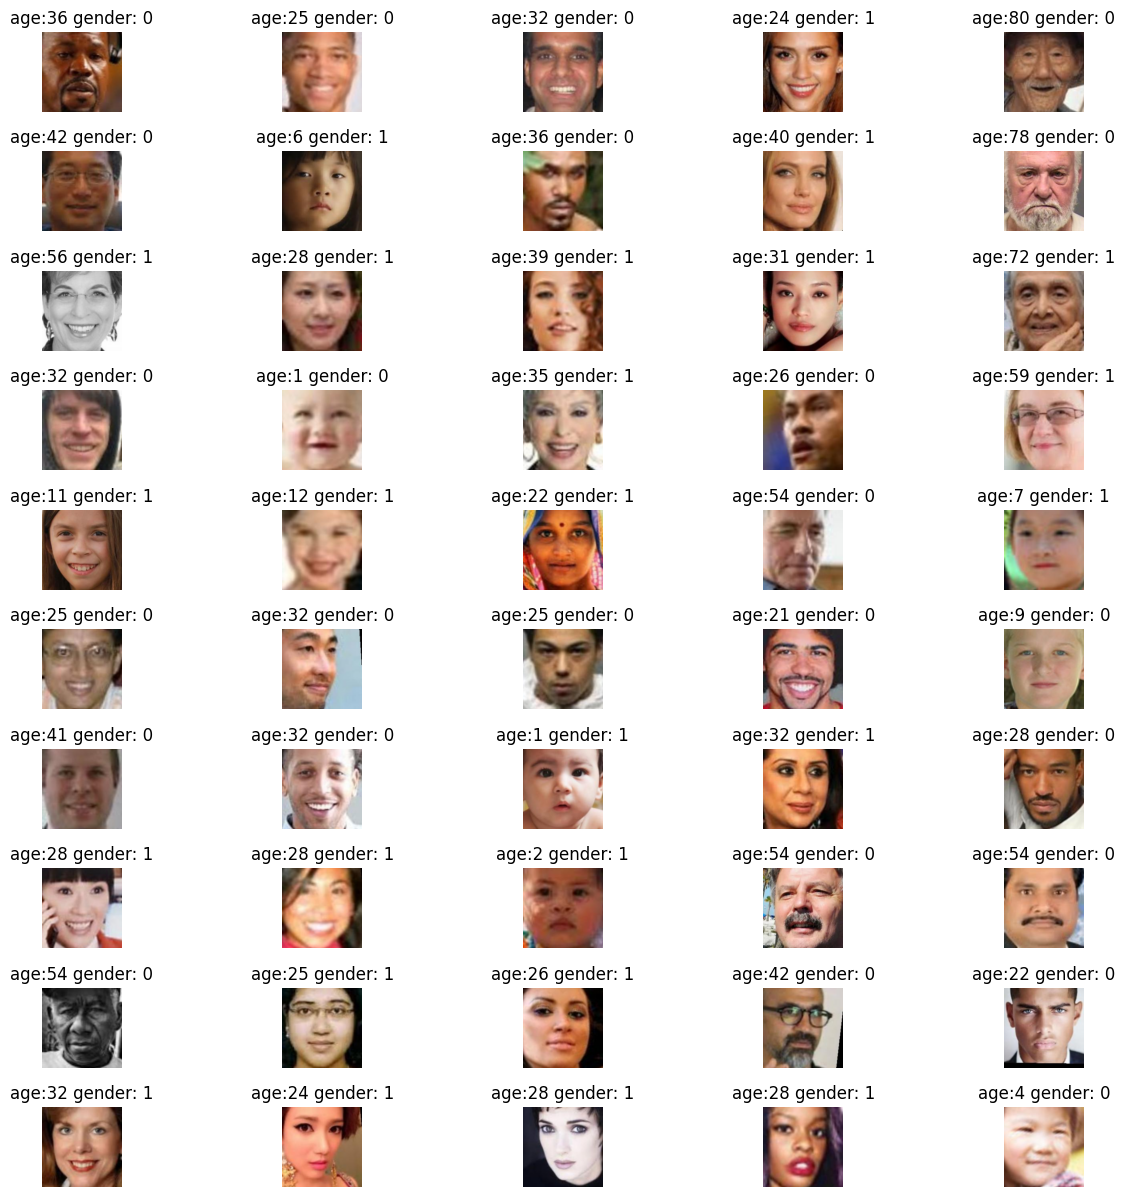

In [ ]:
fig = plt.figure(figsize=(15,15))
index = 1
for i in range(50):
  img = cv2.imread("/content/dataset/UTKFace/"+data.filename[i])
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img,(224,224))
  plt.subplot(10,5,index)
  plt.subplots_adjust(hspace=0.5)
  plt.title(f"age:{data.age[i]} gender: {data.gender[i]}")
  plt.imshow(img)
  plt.axis("off")
  index +=1
plt.show()

## extracting and preparing dataset for training

In [ ]:
from tqdm import tqdm

## using grayscale format due to limited resourses available and dataset is too large

In [ ]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img('/content/dataset/UTKFace/'+image, color_mode='grayscale')
        img = img.resize((128, 128), Image.LANCZOS)
        img = np.array(img)
        features.append(img)

    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [ ]:
X = extract_features(data['filename'])

100%|██████████| 23708/23708 [00:36<00:00, 651.05it/s]


In [ ]:
X.shape

(23708, 128, 128, 1)

In [ ]:
X = X/255.0 # normalizing inputs

In [ ]:
y_gender = np.array(data['gender'])
y_age = np.array(data['age'])

## we will have 2 FCs that separtly outputs age and classify gender basically one is for regression task (age) and other for classification task(gender)

In [ ]:
inputs = Input(((128, 128, 1)))
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu',padding='same') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu',padding='same') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu',padding='same') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu',padding='same') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)
flatten = Flatten() (maxp_4)
dense_1 = Dense(256, activation='relu') (flatten)
dense_2 = Dense(256, activation='relu') (flatten)
dropout_1 = Dropout(0.4) (dense_1)
dropout_2 = Dropout(0.4) (dense_2)
dene_3 = Dense(128, activation='relu') (dropout_1)
dene_4 = Dense(128, activation='relu') (dropout_2)
dropout_3 = Dropout(0.4) (dene_3)
dropout_4 = Dropout(0.4) (dene_4)
dense_5 = Dense(64, activation='relu') (dropout_3)
dense_6 = Dense(64, activation='relu') (dropout_4)
dropout_5 = Dropout(0.4) (dense_5)
dropout_6 = Dropout(0.4) (dense_6)
output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_5)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_6)
model = Model(inputs=[inputs], outputs=[output_1, output_2])
model.compile(loss=['binary_crossentropy', 'mse'], optimizer='adam', metrics=['accuracy', 'mse'])

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 32)   │            320 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 32)     │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 64, 64, 64)     │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 32, 32, 128)    │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 16, 16, 128)    │              0 │ conv2d_2[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 16, 16, 256)    │        295,168 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 8, 8, 256)      │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 16384)          │              0 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │      4,194,560 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 256)            │      4,194,560 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 256)            │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 128)            │         32,896 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 128)            │         32,896 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 128)            │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)  

 Total params: 8,859,394 (33.80 MB)

 Trainable params: 8,859,394 (33.80 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(x=X, y=[y_gender, y_age], batch_size=64, epochs=100, validation_split=0.4)

Epoch 1/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 32s 87ms/step - age_out_mse: 600.9602 - gender_out_accuracy: 0.5050 - loss: 601.7004 - val_age_out_mse: 370.8041 - val_gender_out_accuracy: 0.5278 - val_loss: 371.4960
Epoch 2/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - age_out_mse: 376.1759 - gender_out_accuracy: 0.5901 - loss: 376.8386 - val_age_out_mse: 200.6621 - val_gender_out_accuracy: 0.7608 - val_loss: 201.1743
Epoch 3/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - age_out_mse: 256.6956 - gender_out_accuracy: 0.7433 - loss: 257.2269 - val_age_out_mse: 250.2792 - val_gender_out_accuracy: 0.7991 - val_loss: 250.7247
Epoch 4/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - age_out_mse: 207.2630 - gender_out_accuracy: 0.7671 - loss: 207.7370 - val_age_out_mse: 151.0293 - val_gender_out_accuracy: 0.8232 - val_loss: 151.4330
Epoch 5/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - age_out_mse: 176.5433 - gender_out_accuracy: 0.7935 - loss: 176.9720 - val_age_out_mse: 115.5273 - val_gende

In [ ]:
model.save('/content/drive/MyDrive/sensviz/agedetectionbest.keras')

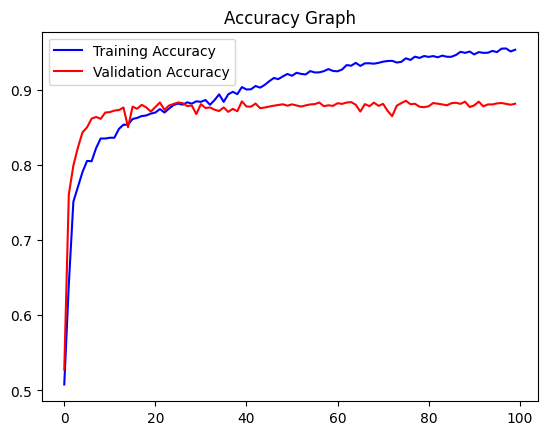

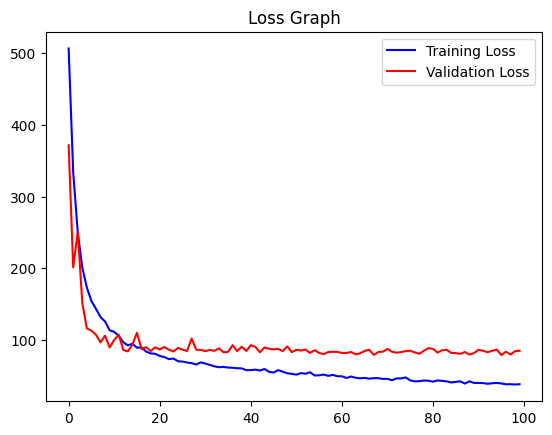

In [ ]:
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

In [ ]:
eval = model.evaluate(X, [y_gender, y_age])

741/741 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - age_out_mse: 22.0773 - gender_out_accuracy: 0.9750 - loss: 22.1582


Original Gender: Female Original Age: 27
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted Gender: Female Predicted Age: 26


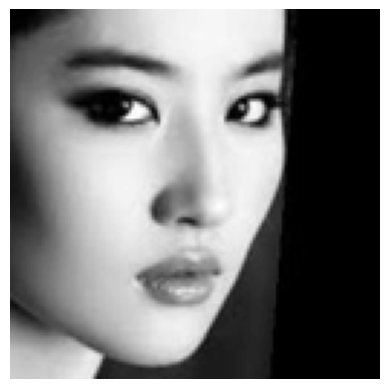

In [ ]:
image_index = 120
gender_dict = {0: 'Male', 1: 'Female'}
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');